# The Battle of Neighborhoods: Find a place to stay in San Francisco

<font size='3.5'> *Applied Data Science Capstone Project* </font>

Author: Wei Hsuan Hsu
<br>
Date: Jul 26, 2021

## Table of contents
* [Introduction / Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

<font size='4'> **Introduction / Business Problem** </font>

Due to the expensive housing price located around the bay area in San Francisco. It is unfriendly for a student to 'survive' in this area. That's the reason why I think it is a good way to combine the skills of data science to analyze the housing price in San Francisco. The beneficiaries (or to say the target audiences) of this notebook are the *real estate brokers* in San Francisco, after viewing this notebook deeply, they may know about the housing price located in each neighborhoods. Therefore, they can use this data to set a reasonable housing price in the market and recommend to a studnet if necessary.

In this project, I will use **Foursquare API** to explore neighborhoods in San Francisco, get the most common venue categories in each neighborhood, use **k-means clustering algorithm** to find similar neighborhoods, use **Folium library** to visualize the neighborhoods in San Francisco and their emerging clusters.

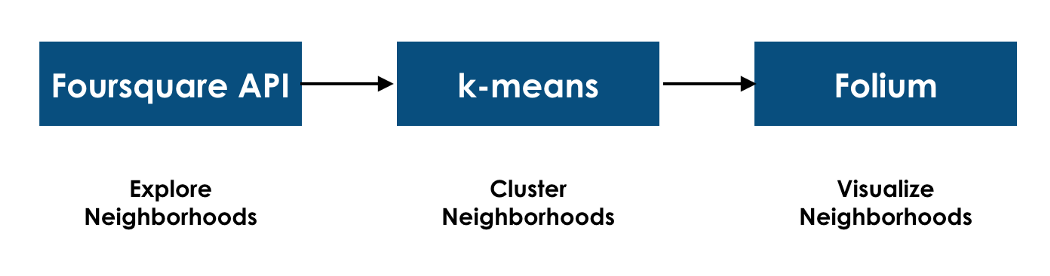

In [10]:
from IPython.display import Image
Image(filename='project.png', width=700, height=700)

<font size='4'> **Data** </font>

In my capstone project, I will use the following free and public available datasets:  
            San Francisco Neighborhoods as ZIP Codes http://www.healthysf.org/bdi/outcomes/zipmap.htm

<font size='4'> **Libraries which are used to develope the project** </font>

- Pandas: For creating and manipulating dataframes.

- Folium: Python visualization library would be used to visualize the neighborhoods cluster distribution of using interactive leaflet map.

- Scikit Learn: For importing k-means clustering.

- JSON: Library to handle JSON files.

- Geocoder: To retrieve Location Data.

- Beautiful Soup and Requests: To scrap and library to handle http requests.

- Matplotlib: Python Plotting Module.

<font size='4'> **Methodology** </font>

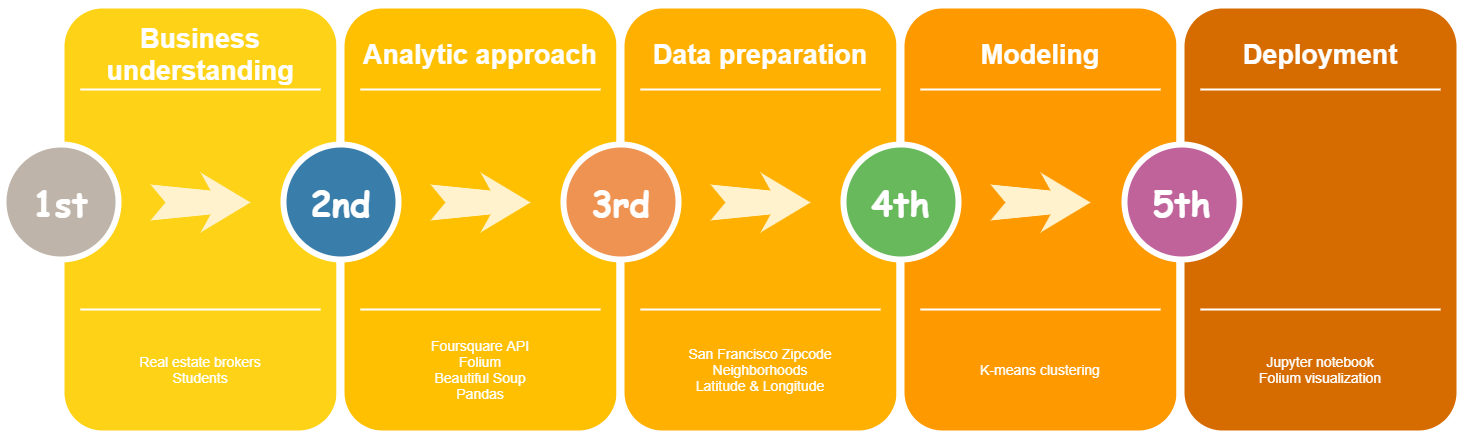

In [125]:
from IPython.display import Image
Image(filename='DS_methodology.png', width=1000, height=1000)

<font size='4'> **Analysis** </font>

In [11]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd

print('modules imported!')

modules imported!


In [128]:
response=requests.get("http://www.healthysf.org/bdi/outcomes/zipmap.htm")
soup=BeautifulSoup(response.text, "lxml")
table=soup.find_all("table")
df=pd.read_html(str(table))
df=pd.DataFrame(df[4])

df.columns=df.iloc[0]
df=df.iloc[1:22, :]
sf_data=df

sf_data.head()

,Zip Code,Neighborhood,Population (Census 2000)
1,94102,Hayes Valley/Tenderloin/North of Market,28991
2,94103,South of Market,23016
3,94107,Potrero Hill,17368
4,94108,Chinatown,13716
5,94109,Polk/Russian Hill (Nob Hill),56322


In [129]:
!pip install uszipcode
from uszipcode import SearchEngine

search=SearchEngine(simple_zipcode=True)

latitude=[]
longitude=[]

for index, row in df.iterrows():
    zipcode=search.by_zipcode(row["Zip Code"]).to_dict()
    latitude.append(zipcode.get('lat'))
    longitude.append(zipcode.get('lng'))

sf_data['Latitude']=latitude
sf_data['Longitude']=longitude

sf_data.head()

,Zip Code,Neighborhood,Population (Census 2000),Latitude,Longitude
1,94102,Hayes Valley/Tenderloin/North of Market,28991,37.780,-122.420
2,94103,South of Market,23016,37.780,-122.410
3,94107,Potrero Hill,17368,37.770,-122.390
4,94108,Chinatown,13716,37.791,-122.409
5,94109,Polk/Russian Hill (Nob Hill),56322,37.790,-122.420


In [56]:
#!pip install geopy
from geopy import geocoders
from geopy.geocoders import Nominatim

address='San Francisco'

geolocator=Nominatim(user_agent='san_francisco_explorer',timeout=10)
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print('The geograpical coordinates of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of San Francisco are 37.7790262, -122.419906.


In [63]:
!conda install -c conda-forge folium=0.5.0 --yes

import folium
print('Folium installed')

Solving environment: ...working... done

# All requested packages already installed.

Folium installed


In [126]:
map_sf=folium.Map(location=[latitude, longitude], zoom_start=10, attr='<a href=https://elsiehsu1997.github.io/>Elsiehsu1997</a>')

for lat, lng, neighborhood in zip(sf_data['Latitude'], sf_data['Longitude'], sf_data['Neighborhood']):
    label='{}'.format(neighborhood)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#42cdff',
        fill_opacity=0.8,
        parse_html=False).add_to(map_sf)  
    
map_sf

In [82]:
CLIENT_ID='C2ZWROWNLFV1140TTVSRHX3TTNNV01MOFLKGT3JZU1D35P02'
CLIENT_SECRET='KNMSPPKBOD1TBHZYKLSU54RRQCTHVO05TX2OHMOXQHGR2TVR' 
VERSION='20180605'
LIMIT=100

print('Your credentails:')
print(' ')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
 
CLIENT_ID: C2ZWROWNLFV1140TTVSRHX3TTNNV01MOFLKGT3JZU1D35P02
CLIENT_SECRET: KNMSPPKBOD1TBHZYKLSU54RRQCTHVO05TX2OHMOXQHGR2TVR


In [84]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results=requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues=pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns=['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [130]:
sf_venues=getNearbyVenues(names=sf_data['Neighborhood'],
                                   latitudes=sf_data['Latitude'],
                                   longitudes=sf_data['Longitude'])
                                  
sf_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,War Memorial Opera House,37.778601,-122.420816,Opera House
1,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,Herbst Theater,37.779548,-122.420953,Concert Hall
2,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,San Francisco Ballet,37.778580,-122.420798,Dance Studio
3,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,Louise M. Davies Symphony Hall,37.777976,-122.420157,Concert Hall
4,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,War Memorial Court,37.779042,-122.420971,Park


In [87]:
sf_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bayview-Hunters Point,6,6,6,6,6,6
Castro/Noe Valley,60,60,60,60,60,60
Chinatown,100,100,100,100,100,100
Haight-Ashbury,31,31,31,31,31,31
Hayes Valley/Tenderloin/North of Market,99,99,99,99,99,99
Ingelside-Excelsior/Crocker-Amazon,44,44,44,44,44,44
Inner Mission/Bernal Heights,52,52,52,52,52,52
Inner Richmond,65,65,65,65,65,65
Lake Merced,17,17,17,17,17,17


In [88]:
print('There are {} uniques categories.'.format(len(sf_venues['Venue Category'].unique())))

There are 218 uniques categories.


In [131]:
sf_onehot=pd.get_dummies(sf_venues[['Venue Category']], prefix="", prefix_sep ="")

sf_onehot['Neighborhood']=sf_venues['Neighborhood'] 

fixed_columns=[sf_onehot.columns[-1]]+list(sf_onehot.columns[:-1])
sf_onehot=sf_onehot[fixed_columns]

sf_onehot.head()

,Neighborhood,ATM,Adult Boutique,Alternative Healer,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Winery,Yemeni Restaurant,Yoga Studio
0,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
sf_grouped=sf_onehot.groupby('Neighborhood').mean().reset_index()
sf_grouped.head()

,Neighborhood,ATM,Adult Boutique,Alternative Healer,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Winery,Yemeni Restaurant,Yoga Studio
0,Bayview-Hunters Point,0.0,0.000000,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,...,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000,0.00,0.0,0.000000
1,Castro/Noe Valley,0.0,0.016129,0.0,0.016129,0.00,0.00,0.0,0.00,0.00,...,0.016129,0.0,0.00,0.00,0.00,0.032258,0.016129,0.00,0.0,0.032258
2,Chinatown,0.0,0.000000,0.0,0.030000,0.01,0.00,0.0,0.01,0.01,...,0.000000,0.0,0.00,0.01,0.01,0.010000,0.000000,0.01,0.0,0.010000
3,Haight-Ashbury,0.0,0.000000,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,...,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000,0.00,0.0,0.034483
4,Hayes Valley/Tenderloin/North of Market,0.0,0.000000,0.0,0.000000,0.00,0.01,0.0,0.01,0.00,...,0.000000,0.0,0.04,0.04,0.00,0.030000,0.010000,0.00,0.0,0.000000


In [97]:
def return_most_common_venues(row, num_top_venues):
    row_categories=row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [133]:
import numpy as np

num_top_venues=10

indicators=['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

neighborhoods_venues_sorted=pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood']=sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:]=return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point,Construction & Landscaping,Motorcycle Shop,Coffee Shop,Park,Marijuana Dispensary,Business Service,ATM,New American Restaurant,Noodle House,North Indian Restaurant
1,Castro/Noe Valley,Gay Bar,Coffee Shop,Park,Yoga Studio,Wine Bar,Grocery Store,Thai Restaurant,Playground,Perfume Shop,Deli / Bodega
2,Chinatown,Hotel,Coffee Shop,Boutique,Men's Store,American Restaurant,Cocktail Bar,Sushi Restaurant,Jewelry Store,Church,Electronics Store
3,Haight-Ashbury,Coffee Shop,Grocery Store,Yoga Studio,Tennis Court,Gastropub,Park,Café,Scenic Lookout,Burrito Place,Bubble Tea Shop
4,Hayes Valley/Tenderloin/North of Market,Vietnamese Restaurant,Hotel,Vegetarian / Vegan Restaurant,Coffee Shop,Cocktail Bar,French Restaurant,Beer Bar,Boutique,Sandwich Place,Wine Bar


In [100]:
from sklearn.cluster import KMeans

kclusters=5
sf_grouped_clustering=sf_grouped.drop('Neighborhood', 1)
kmeans=KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)

kmeans.labels_[0:10] 

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [134]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sf_merged=sf_data
sf_merged=sf_merged.merge(neighborhoods_venues_sorted, on = 'Neighborhood')

sf_merged.head()

,Zip Code,Neighborhood,Population (Census 2000),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94102,Hayes Valley/Tenderloin/North of Market,28991,37.780,-122.420,2,Vietnamese Restaurant,Hotel,Vegetarian / Vegan Restaurant,Coffee Shop,Cocktail Bar,French Restaurant,Beer Bar,Boutique,Sandwich Place,Wine Bar
1,94103,South of Market,23016,37.780,-122.410,2,Coffee Shop,Vietnamese Restaurant,Sandwich Place,Wine Bar,Bakery,Cocktail Bar,Pizza Place,Theater,Performing Arts Venue,Bar
2,94107,Potrero Hill,17368,37.770,-122.390,2,Food Truck,Coffee Shop,Gym,Park,Harbor / Marina,Pizza Place,Pharmacy,Plaza,Street Food Gathering,Café
3,94108,Chinatown,13716,37.791,-122.409,2,Hotel,Coffee Shop,Boutique,Men's Store,American Restaurant,Cocktail Bar,Sushi Restaurant,Jewelry Store,Church,Electronics Store
4,94109,Polk/Russian Hill (Nob Hill),56322,37.790,-122.420,2,Grocery Store,Bar,Wine Bar,Diner,Thai Restaurant,Sushi Restaurant,Café,Gym / Fitness Center,Massage Studio,Pet Store


In [111]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters=folium.Map(location=[latitude, longitude], zoom_start=10, attr='<a href=https://elsiehsu1997.github.io/>Elsiehsu1997</a>')

x=np.arange(kclusters)
ys=[i+x+(i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

for lat, lon, neigh, cluster in zip(sf_merged['Latitude'], sf_merged['Longitude'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label=folium.Popup(str(neigh)+' Cluster '+str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<font size='4'> **Results and Discussion by Cluster** </font>

### Cluster Labels 0

In [112]:
sf_merged.loc[sf_merged['Cluster Labels']==0, sf_merged.columns[[1]+list(range(5, sf_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Twin Peaks-Glen Park,0,Park,Yoga Studio,Thai Restaurant,Gift Shop,Café,North Indian Restaurant,Coffee Shop,Burger Joint,Mexican Restaurant,Scenic Lookout


### Cluster Labels 1

In [114]:
sf_merged.loc[sf_merged['Cluster Labels']==1, sf_merged.columns[[1]+list(range(5, sf_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Bayview-Hunters Point,1,Motorcycle Shop,Art Gallery,Gourmet Shop,Coffee Shop,Pet Store,Marijuana Dispensary,ATM,Pastry Shop,New American Restaurant,Noodle House


### Cluster Labels 2

In [115]:
sf_merged.loc[sf_merged['Cluster Labels']==2, sf_merged.columns[[1]+list(range(5, sf_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hayes Valley/Tenderloin/North of Market,2,Vietnamese Restaurant,Hotel,Vegetarian / Vegan Restaurant,Coffee Shop,Cocktail Bar,French Restaurant,Beer Bar,Boutique,Sandwich Place,Wine Bar
1,South of Market,2,Coffee Shop,Vietnamese Restaurant,Sandwich Place,Wine Bar,Bakery,Pizza Place,Cocktail Bar,Theater,Mexican Restaurant,Bar
2,Potrero Hill,2,Food Truck,Coffee Shop,Gym,Park,Pharmacy,Café,Street Food Gathering,Pizza Place,Pier,Yoga Studio
3,Chinatown,2,Hotel,Coffee Shop,Boutique,Men's Store,American Restaurant,Cocktail Bar,Sushi Restaurant,Jewelry Store,Church,Electronics Store
4,Polk/Russian Hill (Nob Hill),2,Grocery Store,Bar,Café,Massage Studio,Diner,Sushi Restaurant,Wine Bar,Thai Restaurant,Pet Store,Gym / Fitness Center
5,Inner Mission/Bernal Heights,2,Mexican Restaurant,Grocery Store,Italian Restaurant,Middle Eastern Restaurant,Art Gallery,Coffee Shop,Gym / Fitness Center,Jewelry Store,Dive Bar,Bakery
6,Ingelside-Excelsior/Crocker-Amazon,2,Pizza Place,Chinese Restaurant,Mexican Restaurant,Bar,Vietnamese Restaurant,Sandwich Place,Coffee Shop,Latin American Restaurant,Deli / Bodega,Bus Station
7,Castro/Noe Valley,2,Gay Bar,Park,Coffee Shop,Yoga Studio,Wine Bar,Thai Restaurant,Grocery Store,Playground,Shoe Store,Cosmetics Shop
8,Western Addition/Japantown,2,Park,Chinese Restaurant,Bakery,Sports Bar,Spa,Sushi Restaurant,Furniture / Home Store,Sandwich Place,Gas Station,Scenic Lookout
9,Parkside/Forest Hill,2,Chinese Restaurant,Park,Light Rail Station,Café,Pizza Place,Sandwich Place,Dim Sum Restaurant,Cocktail Bar,Spa,Cosmetics Shop


### Cluster Labels 3

In [116]:
sf_merged.loc[sf_merged['Cluster Labels']==3, sf_merged.columns[[1]+list(range(5, sf_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Visitacion Valley/Sunnydale,3,Baseball Field,Scenic Lookout,Garden,Performing Arts Venue,Park,Tennis Court,Music Venue,Nail Salon,New American Restaurant,Noodle House


### Cluster Labels 4

In [117]:
sf_merged.loc[sf_merged['Cluster Labels']==4, sf_merged.columns[[1]+list(range(5, sf_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,St. Francis Wood/Miraloma/West Portal,4,Scenic Lookout,Park,Fountain,Bus Line,Plaza,Playground,Music Venue,Nail Salon,New American Restaurant,Noodle House


<font size='4'> **Conclusion** </font>

Because there are only a few/limited neighborhoods in San Francisco, we can’t really get insightful clusters with highly commercial values. However, if you want, you can try to play with bigger cities’ datasets, such as : Toronto, New York.